#3.2. Linear Regression Implementation from Scratch

In this section, we will implement the entire method from scratch, including:
* the data pipeline, the model,
* the loss function,
* the minibatch stochastic gradient descent optimizer.

In this section, we will rely only on tensors and auto differentiation. Afterwards, we will introduce a more concise implementation, taking advantage of bells and whistles of deep learning frameworks.

The following additional libraries are needed to run this notebook.

In [2]:
!pip install d2l==0.17.2

In [3]:
%matplotlib inline
import random
import tensorflow as tf
from d2l import tensorflow as d2l

##3.2.1. Generating the Dataset

To keep things simple, we will construct an artificial dataset according to a linear model with additive noise. Our task will be to recover this model’s parameters using the finite set of examples contained in our dataset. We will keep the data low-dimensional so we can visualize it easily. In the following code snippet, we generate a dataset containing 1000 examples, each consisting of 2 features sampled from a standard normal distribution.

You could think of $\epsilon$ as capturing potential
measurement errors on the features and labels.
We will assume that the standard assumptions hold and thus
that $\epsilon$ obeys a normal distribution with mean of 0.
To make our problem easy, we will set its standard deviation to 0.01.
The following code generates our synthetic dataset.

In [4]:
def synthetic_data(w, b, num_examples):  
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Note that each row in features consists of a 2-dimensional data example and that each row in labels consists of a 1-dimensional label value (a scalar).

In [5]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([1.0250294 1.1762158], shape=(2,), dtype=float32) 
label: tf.Tensor([2.2508392], shape=(1,), dtype=float32)


In [7]:
pip install matplotlib==3.0.2

     |████████████████████████████████| 12.9 MB 3.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.2 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


By generating a scatter plot using the second feature features[:, 1] and labels, we can clearly observe the linear correlation between the two.

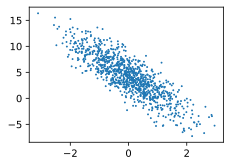

In [8]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

The output of cell [6]:

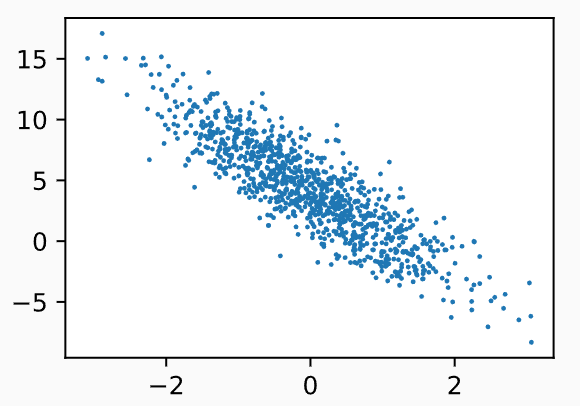

##3.2.2. Reading the Dataset
Recall that training models consists of making multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model. Since this process is so fundamental to training machine learning algorithms, it is worth defining a utility function to shuffle the dataset and access it in minibatches.

In the following code, we define the data_iter function to demonstrate one possible implementation of this functionality. The function takes a batch size, a matrix of features, and a vector of labels, yielding minibatches of the size batch_size. Each minibatch consists of a tuple of features and labels.

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In general, note that we want to use reasonably sized minibatches to take advantage of the GPU hardware, which excels at parallelizing operations. Because each example can be fed through our models in parallel and the gradient of the loss function for each example can also be taken in parallel, GPUs allow us to process hundreds of examples in scarcely more time than it might take to process just a single example.

To build some intuition, let us read and print the first small batch of data examples. The shape of the features in each minibatch tells us both the minibatch size and the number of input features. Likewise, our minibatch of labels will have a shape given by batch_size.

In [10]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 0.59579617 -0.6716898 ]
 [ 0.9533826  -0.5242842 ]
 [ 1.2908108  -0.4615673 ]
 [ 0.04143323  0.10769907]
 [ 1.4597572  -0.2574138 ]
 [ 1.570257    0.246215  ]
 [-0.82540405 -0.16280185]
 [-1.0473804   0.15127851]
 [-1.0139476  -1.2053298 ]
 [ 0.6071782  -0.13693416]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[7.6884212]
 [7.892584 ]
 [8.333765 ]
 [3.889605 ]
 [7.9914827]
 [6.5017476]
 [3.1015568]
 [1.6069283]
 [6.275563 ]
 [5.873367 ]], shape=(10, 1), dtype=float32)


As we run the iteration, we obtain distinct minibatches successively until the entire dataset has been exhausted. While the iteration implemented above is good for didactic purposes, it is inefficient in ways that might get us in trouble on real problems. For example, it requires that we load all the data in memory and that we perform lots of random memory access. The built-in iterators implemented in a deep learning framework are considerably more efficient and they can deal with both data stored in files and data fed via data streams.

##3.2.3. Initializing Model Parameters

Before we can begin optimizing our model’s parameters by minibatch stochastic gradient descent, we need to have some parameters in the first place. In the following code, we initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and setting the bias to 0.

In [11]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

After initializing our parameters, our next task is to update them until they fit our data sufficiently well. Each update requires taking the gradient of our loss function with respect to the parameters. Given this gradient, we can update each parameter in the direction that may reduce the loss.

Since nobody wants to compute gradients explicitly (this is tedious and error prone), we use automatic differentiation to compute the gradient.

##3.2.4. Defining the Model

Next, we must [**define our model,
relating its inputs and parameters to its outputs.**]
Recall that to calculate the output of the linear model,
we simply take the matrix-vector dot product
of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
Note that below $\mathbf{Xw}$  is a vector and $b$ is a scalar.
Recall the broadcasting mechanism.
When we add a vector and a scalar,
the scalar is added to each component of the vector.

In [13]:
def linreg(X, w, b): 
    """The linear regression model."""
    return tf.matmul(X, w) + b

#3.2.5. Defining the Loss Function

Here we will use the squared loss function. In the implementation, we need to transform the true value y into the predicted value’s shape y_hat. The result returned by the following function will also have the same shape as y_hat.

In [15]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

##3.2.6. Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset, we will estimate the gradient of the loss with respect to our parameters. Next, we will update our parameters in the direction that may reduce the loss. The following code applies the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size. The size of the update step is determined by the learning rate lr. Because our loss is calculated as a sum over the minibatch of examples, we normalize our step size by the batch size (batch_size), so that the magnitude of a typical step size does not depend heavily on our choice of the batch size.

In [16]:
def sgd(params, grads, lr, batch_size): 
    """Minibatch stochastic gradient descent."""
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

##3.2.7. Training
Now that we have all of the parts in place, we are ready to implement the main training loop. 

In each iteration, we will grab a minibatch of training examples, and pass them through our model to obtain a set of predictions. After calculating the loss, we initiate the backwards pass through the network, storing the gradients with respect to each parameter. Finally, we will call the optimization algorithm sgd to update the model parameters.

In each epoch, we will iterate through the entire dataset (using the data_iter function) once passing through every example in the training dataset (assuming that the number of examples is divisible by the batch size). The number of epochs num_epochs and the learning rate lr are both hyperparameters, which we set here to 3 and 0.03, respectively. Unfortunately, setting hyperparameters is tricky and requires some adjustment by trial and error.

In [17]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on l with respect to [`w`, `b`]
        dw, db = g.gradient(l, [w, b])
        # Update parameters using their gradient
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

epoch 1, loss 0.035114
epoch 2, loss 0.000135
epoch 3, loss 0.000051


Evaluate our success in training by comparing the true parameters with those that we learned through our training loop. Indeed they turn out to be very close to each other.

In [18]:
print(f'error in estimating w: {true_w - tf.reshape(w, true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: [-0.00039077 -0.00059557]
error in estimating b: [0.00027227]
